## 2016 Census API Dataset: Poverty vs College Education

In this notebook we are going to use the US Census API along with Python, Pandas and Numpy to organize and analyze the raw census data from 2016. Then we are going to use Matplotlib and Gmaps to make some data visualizations.

We will try to answer the questions below:

*   Does a states poverty rate have an impact on the amount of its population that have college degrees? 
*	What states have a larger population without degrees than with degrees?
*	Do we see any difference in Puerto Rico compared to our 50 states?
*	Is college education impacted by poverty at a state level or does it differ based on counties with a state?
*	Is there a difference in poverty rate and its potential impact on education between states within middle America and coastal states? Such as California or New York?

Before we get started you can find documentation on the US Census API [here.](https://github.com/datamade/census)

You can also find the Census column aliases [here.](https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b) (Example: B19013_001E = Median household income)


In [8]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from census import Census

# Import census key and set to year 2016
from config_census import census_key
c = Census(census_key, year=2016)

In [9]:
# Census API documentation can be found at:
# https://github.com/datamade/census

# Census column aliases can be found at:
# https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b

# Run Census Search to retrieve data on by state
census_data = c.acs5.get(("NAME", "B01003_001E", "B17001_002E", "B15003_002E","B15003_002E", 
                          "B15003_017E", "B15003_018E", "B15003_021E", "B15003_022E", "B15003_023E", 
                          "B15003_024E", "B15003_025E"), {'for': 'state:*'})

# Create datafram using pandas
census_df = pd.DataFrame(census_data)

# Relabel and Reorder Columns
census_df = census_df.rename(columns={"state": "State",
                                      "NAME": "Name",
                                      "B01003_001E": "Population",
                                      "B17001_002E": "Poverty Count",
                                      "B15003_002E": "No Education", 
                                      "B15003_017E": "High School Education", 
                                      "B15003_018E": "GED Education",
                                      "B15003_021E": "Associates Degree",
                                      "B15003_022E": "Bachelors Degree", 
                                      "B15003_023E": "Masters Degree",
                                      "B15003_024E": "Professional Degree",
                                      "B15003_025E": "Doctoral Degree"
                                      })

census_df = census_df.reindex(columns=["Name", "Population", "Poverty Count",  "No Education", "High School Education", 
                                       "GED Education", "Associates Degree", "Bachelors Degree" , "Masters Degree", 
                                       "Professional Degree", "Doctoral Degree"])

# Print
census_df.head()

,Name,Population,Poverty Count,No Education,High School Education,GED Education,Associates Degree,Bachelors Degree,Masters Degree,Professional Degree,Doctoral Degree
0,Alabama,4841164.0,868666.0,42577.0,828205.0,181388.0,258502.0,492382.0,208839.0,49283.0,32572.0
1,Alaska,736855.0,72826.0,3020.0,106169.0,24342.0,39133.0,86551.0,35423.0,8522.0,5029.0
2,Arizona,6728577.0,1165636.0,62538.0,898657.0,179701.0,379207.0,777681.0,333226.0,76987.0,53531.0
3,Arkansas,2968472.0,542431.0,23010.0,561132.0,122754.0,127004.0,273557.0,108055.0,24517.0,18317.0
4,California,38654206.0,6004257.0,673089.0,4678279.0,582625.0,1995579.0,5136043.0,2045487.0,597874.0,397083.0


In [10]:
# Create Poverty Rate column (Poverty Count / Population)
census_df["Poverty Rate"] = 100 * census_df["Poverty Count"].astype(int) / census_df["Population"].astype(int)

# Create No Degree column
census_df["No Degree"] = census_df["No Education"] + census_df["High School Education"] + census_df["GED Education"]

# Create Degree column
census_df["Degree"] = census_df["Associates Degree"] + census_df["Bachelors Degree"] + census_df["Masters Degree"] \
                    + census_df["Professional Degree"] + census_df["Doctoral Degree"]

# All columns needed for data by state saved to .csv in case needed
census_df.to_csv("Census_by_state_all_columns.csv", index=False)

# Print
census_df.head()

,Name,Population,Poverty Count,No Education,High School Education,GED Education,Associates Degree,Bachelors Degree,Masters Degree,Professional Degree,Doctoral Degree,Poverty Rate,No Degree,Degree
0,Alabama,4841164.0,868666.0,42577.0,828205.0,181388.0,258502.0,492382.0,208839.0,49283.0,32572.0,17.943329,1052170.0,1041578.0
1,Alaska,736855.0,72826.0,3020.0,106169.0,24342.0,39133.0,86551.0,35423.0,8522.0,5029.0,9.883356,133531.0,174658.0
2,Arizona,6728577.0,1165636.0,62538.0,898657.0,179701.0,379207.0,777681.0,333226.0,76987.0,53531.0,17.323663,1140896.0,1620632.0
3,Arkansas,2968472.0,542431.0,23010.0,561132.0,122754.0,127004.0,273557.0,108055.0,24517.0,18317.0,18.273071,706896.0,551450.0
4,California,38654206.0,6004257.0,673089.0,4678279.0,582625.0,1995579.0,5136043.0,2045487.0,597874.0,397083.0,15.533257,5933993.0,10172066.0


In [4]:
# Only use necessary columns
census_df = census_df.reindex(columns=["Name", "Population", "Poverty Rate", "No Degree", "Degree"])

# Add No Degree % column by dividing the state population with no degree against all total degrees and no degree per state
census_df["No Degree %"] = census_df["No Degree"] / (census_df["No Degree"] + census_df["Degree"])
census_df["No Degree %"] = round(census_df["No Degree %"]*100,2)

# Add Degree % column by dividing the state population with a degree against all total degrees and no degree per state
census_df["Degree %"] = census_df["Degree"] / (census_df["No Degree"] + census_df["Degree"])
census_df["Degree %"] = round(census_df["Degree %"]*100,2)

# Print
census_df.head()

,Name,Population,Poverty Rate,No Degree,Degree,No Degree %,Degree %
0,Alabama,4841164.0,17.943329,1052170.0,1041578.0,50.25,49.75
1,Alaska,736855.0,9.883356,133531.0,174658.0,43.33,56.67
2,Arizona,6728577.0,17.323663,1140896.0,1620632.0,41.31,58.69
3,Arkansas,2968472.0,18.273071,706896.0,551450.0,56.18,43.82
4,California,38654206.0,15.533257,5933993.0,10172066.0,36.84,63.16


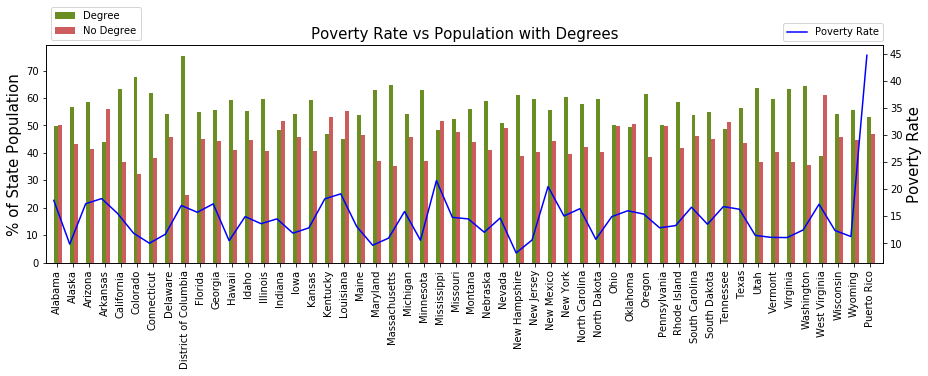

In [6]:
# Create bar charts of degree and no degree per state of % of population 
colors = ['olivedrab', 'indianred']
labels = ["Degree" , "No Degree"]
ax1 = census_df.plot.bar(x="Name", y=["Degree %", "No Degree %"], figsize=(15,4), color=colors, align='edge', label=labels)

# Add secondary y axis line chart for poverty
ax2 = census_df.plot.line(x="Name", y="Poverty Rate", color='b', rot=90, ax=ax1, secondary_y=True)

# Clean up and label chart
plt.title("Poverty Rate vs Population with Degrees", fontsize=15)
plt.xticks(np.arange(len(census_df["Name"]))+0.2, census_df["Name"])
plt.xlim(-.5, len(census_df["Name"]))
ax1.legend(loc='center', bbox_to_anchor=(.06, 1.1), ncol=1)
ax2.legend(loc='center', bbox_to_anchor=(.94, 1.06), ncol=1)
ax1.set_xlabel("")
ax1.set_ylabel('% of State Population', fontsize=15)
ax2.set_ylabel('Poverty Rate', fontsize=15)

# Save Figure
plt.savefig('Poverty Rate vs Population with Degrees.png')

# Show plot
plt.show()